[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import math
from itertools import combinations, combinations_with_replacement

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


# [Thinking like Transformers](https://arxiv.org/abs/2106.06981)

Here we code our 'toy' GPT without any training in order to compute histograms. For the input sequence `<BOS>,a,a,b,a,b,c`, the output should be `0,3,3,2,3,2,1` as the letter `a` appears 3 times, the letter `b` 2 times and the letter `c` once. Each letter is replaced by its number of occurences (except `<BOS>` replaced by a `0`). 

## Self-Attention

First start by coding your Self-Attention layer (do not worry about initialization for the moment).

In [3]:
class SelfAttentionLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_channels = config.n_channels
        self.key_channels = config.key_channels
        self.Query = nn.Linear(self.n_channels, self.key_channels, bias=False)
        self.Key = nn.Linear(self.n_channels, self.key_channels, bias = False)
        self.Value = nn.Linear(self.n_channels, self.n_channels, bias = False)
    
    def _init_hist(self):
        self.Query.weight.data = 100*torch.eye(self.key_channels, self.n_channels)
        self.Key.weight.data = 100*torch.eye(self.key_channels,self.n_channels)
        self.Value.weight.data = torch.zeros(self.n_channels,self.n_channels)
        self.Value.weight.data[0,0] = 1.0
        
    def _init_id(self):
        self.Query.weight.data = 100*torch.eye(self.key_channels, self.n_channels)
        self.Key.weight.data = 100*torch.eye(self.key_channels,self.n_channels)
        self.Value.weight.data = torch.eye(self.key_channels,self.n_channels)        
        
    def forward(self, x): # x (bs, T, ic)
        Q = self.Query(x) # (bs, T, kc)
        K = self.Key(x)/math.sqrt(self.key_channels) # (bs, T, kc)
        V = self.Value(x) # (bs, T, oc)
        A = torch.einsum('btk,bsk->bst', Q, K) # (bs, T, kc), (bs, T, kc) -> (bs , T, T)
        A = F.softmax(A, dim=-1)
        y = A @ V # (bs, T, oc)
        return y, A

Check your implementation.

In [4]:
class toy_config:
    n_channels = 3
    key_channels = 3
    
sa_toy = SelfAttentionLayer(toy_config)

In [5]:
input = torch.randn(5,10,3)
y,A = sa_toy(input)

In [6]:
y.shape

torch.Size([5, 10, 3])

In [7]:
torch.sum(A, dim=-1)

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000]], grad_fn=<SumBackward1>)

## identity GPT

We first start with a simple example where we want to contruct the identity map. Clearly, in this case, we can just use the skip connections present in real transformer block. Instead, we will ignore these skip connections and use the self-attention layer. In this practical, we will ignore the layer norm.

To make our life simpler, we encode `<BOS>` with a `0`, letter `a` with a `1` and so on...

If we give as input the sequence `0,1,1,2,3,4,2,3,1`, we want to get the same sequence as output. This is clearly doable with a transformer block as follows:
- take one-hot encoding of each token 
- take Query and Key matrices as `100*Id`
- take Value matrix as `Id`
As a result, the output of the self-attention layer will be the same as the input.

Then take a Feed Forward Network which is simply the identity map as coded below:

In [8]:
class Block_id(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attn = SelfAttentionLayer(config)
        self.fake_mlp = (lambda x : x)
        self.attn._init_id()

    def forward(self, x):
        x, A = self.attn(x)
        x = self.fake_mlp(x)
        return x, A

In [9]:
nb_digits = 4
class config:
    n_channels=nb_digits+1
    key_channels=nb_digits+1

In [10]:
bid = Block_id(config)
one_sample = torch.tensor([[0.,0.,1.,0.,0.],[0.,1.,0.,0.,0.]]).unsqueeze(0)
bid(one_sample)

(tensor([[[0., 0., 1., 0., 0.],
          [0., 1., 0., 0., 0.]]], grad_fn=<UnsafeViewBackward0>),
 tensor([[[1., 0.],
          [0., 1.]]], grad_fn=<SoftmaxBackward0>))

Now to have really the identity map, we need to project back the one-hot encoding and this can be done with a linear layer (with good weights initialization).

In [11]:
class GPT_id(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_channels = config.n_channels
        self.tok_emb = nn.Embedding(self.n_channels,self.n_channels)
        self.block = Block_id(config)
        self.head = nn.Linear(self.n_channels, 1, bias = False)
        self._init_weights()
        
    def _init_weights(self):
        self.tok_emb.weight.data = torch.eye(self.n_channels,self.n_channels)
        self.head.weight.data = torch.arange(0,self.n_channels,dtype=torch.float32)
        
    def forward(self, idx):
        x = self.tok_emb(idx)
        x, A = self.block(x)
        return self.head(x), A

In [12]:
gid = GPT_id(config)

In [13]:
one_sample = torch.tensor([0,1,1,2,3,4,2,3,1]).unsqueeze(0)
y, A = gid(one_sample)

In [14]:
y == one_sample

tensor([[True, True, True, True, True, True, True, True, True]])

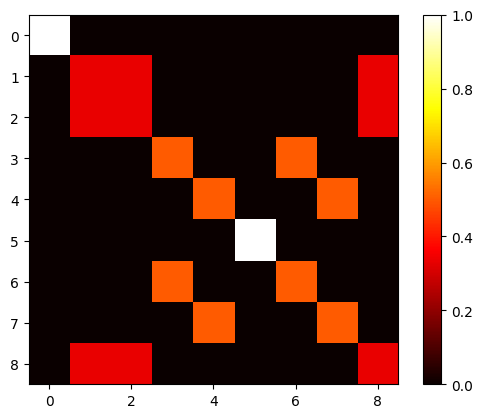

In [15]:
plt.imshow(A[0,:,:].cpu().data, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

## histogram GPT

Now we need to adapt previous case to code our 'toy' transformer block and your 'toy' GPT to compute histograms:
- you will need to find a good initialization for the Quey, Key and Value matrices
- for the feed forward network, you can fake the mlp with any function you'd like.

In [16]:
class Block_hist(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attn = SelfAttentionLayer(config)
        self.fake_mlp = (lambda x :1/x.sum(-1, keepdim=True)-1)
        self.attn._init_hist()

    def forward(self, x):
        x, A = self.attn(x)
        x = self.fake_mlp(x)
        return x, A

In [17]:
class GPT_hist(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_channels = config.n_channels
        self.tok_emb = nn.Embedding(self.n_channels,self.n_channels)
        self.block = Block_hist(config)
        self._init_weights()
        
    def _init_weights(self):
        self.tok_emb.weight.data = torch.eye(self.n_channels,self.n_channels)
        self.tok_emb.weight.data[0,:] = torch.ones(self.n_channels)
        
    def forward(self, idx):
        x = self.tok_emb(idx)
        x, A = self.block(x)
        return x, A

Check your implementation by first choosing properly your configuration:

In [18]:
gh = GPT_hist(config)

In [19]:
one_sample = torch.tensor([0,1,1,2,3,4,2,3,1]).unsqueeze(0)
y, A = gh(one_sample)
y

tensor([[[0.],
         [3.],
         [3.],
         [2.],
         [2.],
         [1.],
         [2.],
         [2.],
         [3.]]], grad_fn=<SubBackward0>)

In [20]:
y.shape

torch.Size([1, 9, 1])

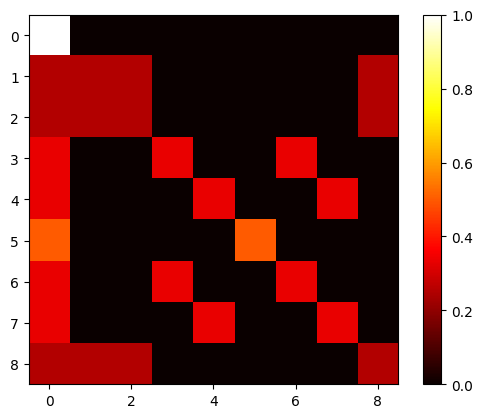

In [21]:
plt.imshow(A[0,:,:].cpu().data, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [22]:
A[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2500],
        [0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000],
        [0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2500]],
       grad_fn=<SelectBackward0>)

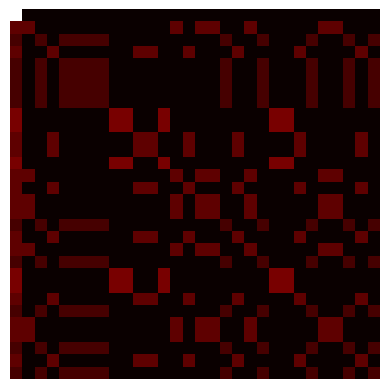

In [23]:
one_sample = torch.randint(1, 5, (1,30))
one_sample[0,0] = 0
y, A = gh(one_sample)
plt.imshow(A[0].cpu().data, cmap='hot', interpolation='nearest')
#plt.colorbar()
plt.axis('off')
plt.show()

# Generating your dataset

Now, we will use a 'micro' GPT to learn the task of histograms. Before that, we will use our 'toy' GPT to generate the dataset. Since GPT is equivariant (a permutation of the input will permute the output), we can always take as input a sequence ordered. We can indeed compute all possible different inputs and this number is not too high. For a sequence of lenght `seq_train=s` with at most `nb_digits=n`, there are ${s+n-1 \choose n-1}$ possibilities. Now for each such sequence, we pass it through our toy GPT to get the label.

In [24]:
seq_train = 30
nb_digits = 4
comb = combinations_with_replacement(range(0,seq_train+1), nb_digits-1)

def make_seq(c, seq_train):
    c_l = [0] + list(c) + [seq_train]
    len_seq = len(c_l)-1
    return [c_l[i+1]-c_l[i] for i in range(len_seq)]

l_comb =  [make_seq(c,seq_train) for c in comb]

len(l_comb)

5456

In [25]:
one_sample.shape

torch.Size([1, 30])

In [26]:
math.comb(seq_train+nb_digits-1, nb_digits-1)

5456

In [27]:
def make_inputs(l_comb, nb_digits=nb_digits):
    inputs = []
    for t in l_comb:
        curr = [0]
        for (i,j) in enumerate(t):
            curr += [i+1 for _ in range(j)]
        inputs.append(torch.tensor(np.array(curr)))
    return inputs

def make_loader(len_seq,nb_digits):
    comb = combinations_with_replacement(range(0,len_seq+1), nb_digits-1)
    l_comb =  [make_seq(c,len_seq) for c in comb]
    inputs = make_inputs(l_comb)
    labels = [(gh(d.unsqueeze(0))[0].squeeze(0).squeeze(1)).type(torch.LongTensor) for d in inputs]
    dataset = list(zip(inputs,labels))
    len_in = len(dataset)
    loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)
    return loader, len_in, inputs

In [28]:
train_loader, size_train, inputs_train = make_loader(seq_train,nb_digits)

In [29]:
size_train

5456

In [30]:
batch_in = next(iter(train_loader))

In [31]:
batch_in[0].shape

torch.Size([128, 31])

In [32]:
batch_in[1].shape

torch.Size([128, 31])

In [33]:
batch_in[0][0]

tensor([0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3])

In [34]:
batch_in[1][0]

tensor([ 0,  2,  2, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12])

# Coding 'micro' GPT

Now we need to code the 'micro' GPT used for learning. The game here is to reuse our `SelfAttentionLayer` above without any modification. The only part that is modified is the hard-coded `fake_mlp` which is now replaced by a real MLP.

In [35]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attn = SelfAttentionLayer(config)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_channels, 4 * config.n_channels),
            nn.ReLU(),
            nn.Linear(4 * config.n_channels, config.n_channels),
        )

    def forward(self, x, verbose=False): # x (bs, T,ic)
        y, A = self.attn(x)# 
        x =  x + y 
        x = x + self.mlp(x)# (bs, T, ic)
        if verbose:
            return x, A
        else:
            return x

In [36]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_channels = config.n_channels
        self.nb_digits = config.nb_digits
        self.tok_emb = nn.Embedding(self.nb_digits+1,self.n_channels)
        self.block = Block(config)
        self.head = nn.Linear(config.n_channels, 1+config.max_hist)
        
    def forward(self, idx, targets=None, verbose=False):
        # shape of idx: (bs, len) 0=bos and 1...nb_digits
        # shape of targets: (bs, len)
        x= self.tok_emb(idx)
        if verbose:
            x, A = self.block(x,verbose=verbose)
        else:
            x = self.block(x) # x: (bs, len, in_channels)
        logits = self.head(x) # logits: (bs, len, max_hist)
        
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1)) # your code here
        if verbose:
            return logits, loss, A
        else:
            return logits, loss

In [37]:
class config_gpt:
    nb_digits = nb_digits
    n_channels = 32 
    key_channels = 64 
    max_hist = seq_train+1

In [38]:
gptmini = GPT(config_gpt)

In [39]:
logits, _ = gptmini(batch_in[0])

In [40]:
logits.shape

torch.Size([128, 31, 32])

In [41]:
_,preds = torch.max(logits,-1)

In [42]:
preds.shape

torch.Size([128, 31])

In [43]:
batch_in[0].shape

torch.Size([128, 31])

In [44]:
torch.sum(preds == batch_in[1])

tensor(81)

In [45]:
def train_model(model, dataloader, size, epochs=1, optimizer=None):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        n_batch = 0
        for inputs,targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            logits, loss = model(inputs,targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #
            # complete the code below:
            _,preds = torch.max(logits,-1)
           
            running_corrects += torch.true_divide(torch.sum(preds == targets.data),targets.shape[0]*targets.shape[1])
            running_loss +=  loss.data.item()
            n_batch += 1
        epoch_loss = running_loss /n_batch
        epoch_acc = running_corrects.data.item() /n_batch
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))

In [46]:
gptmini = GPT(config_gpt)
gptmini = gptmini.to(device)
lr = 0.01
optimizer = torch.optim.Adam(gptmini.parameters(),lr = lr)

In [47]:
len_train = (seq_train+1)*size_train
train_model(gptmini,train_loader,size_train,15,optimizer)

Loss: 2.8989 Acc: 0.1404
Loss: 2.3290 Acc: 0.2366
Loss: 1.8414 Acc: 0.3420
Loss: 1.5484 Acc: 0.4130
Loss: 1.3893 Acc: 0.4707
Loss: 1.1710 Acc: 0.5449
Loss: 1.2235 Acc: 0.5548
Loss: 1.1447 Acc: 0.5624
Loss: 0.9973 Acc: 0.5997
Loss: 1.0354 Acc: 0.5942
Loss: 0.7673 Acc: 0.7260
Loss: 2.0153 Acc: 0.5679
Loss: 1.3302 Acc: 0.5225
Loss: 1.0100 Acc: 0.6331
Loss: 0.9950 Acc: 0.6192


In [48]:
lr = 0.005
optimizer = torch.optim.Adam(gptmini.parameters(),lr = lr)
train_model(gptmini,train_loader,len_train,15,optimizer)

Loss: 1.6273 Acc: 0.5895
Loss: 0.8585 Acc: 0.7432
Loss: 0.7456 Acc: 0.7976
Loss: 0.6564 Acc: 0.8209
Loss: 0.6194 Acc: 0.8226
Loss: 0.5965 Acc: 0.8187
Loss: 0.5400 Acc: 0.8298
Loss: 0.4599 Acc: 0.8847
Loss: 0.5487 Acc: 0.7952
Loss: 0.4360 Acc: 0.8818
Loss: 0.4119 Acc: 0.8772
Loss: 0.5157 Acc: 0.7874
Loss: 0.4393 Acc: 0.8326
Loss: 0.3695 Acc: 0.8922
Loss: 0.3329 Acc: 0.9038


In [49]:
lr = 0.001
optimizer = torch.optim.Adam(gptmini.parameters(),lr = lr)
train_model(gptmini,train_loader,len_train,15,optimizer)

Loss: 0.3562 Acc: 0.9074
Loss: 0.2381 Acc: 0.9965
Loss: 0.2271 Acc: 0.9964
Loss: 0.2194 Acc: 0.9964
Loss: 0.2115 Acc: 0.9953
Loss: 0.1993 Acc: 0.9976
Loss: 0.1878 Acc: 0.9975
Loss: 0.1770 Acc: 0.9978
Loss: 0.1705 Acc: 0.9973
Loss: 0.1589 Acc: 0.9982
Loss: 0.1484 Acc: 0.9986
Loss: 0.1395 Acc: 0.9978
Loss: 0.1428 Acc: 0.9915
Loss: 0.1259 Acc: 0.9978
Loss: 0.1150 Acc: 0.9989


In [50]:
lr = 0.0001
optimizer = torch.optim.Adam(gptmini.parameters(),lr = lr)
train_model(gptmini,train_loader,len_train,15,optimizer)

Loss: 0.1069 Acc: 0.9995
Loss: 0.1024 Acc: 0.9998
Loss: 0.1009 Acc: 1.0000
Loss: 0.0997 Acc: 0.9999
Loss: 0.0980 Acc: 0.9999
Loss: 0.0966 Acc: 1.0000
Loss: 0.0950 Acc: 1.0000
Loss: 0.0933 Acc: 1.0000
Loss: 0.0919 Acc: 1.0000
Loss: 0.0906 Acc: 0.9998
Loss: 0.0889 Acc: 1.0000
Loss: 0.0872 Acc: 1.0000
Loss: 0.0857 Acc: 1.0000
Loss: 0.0841 Acc: 1.0000
Loss: 0.0826 Acc: 1.0000


In [51]:
one_batch = batch_in[0].to(device)
logits, loss, A = gptmini(one_batch,verbose=True)
A.shape

torch.Size([128, 31, 31])

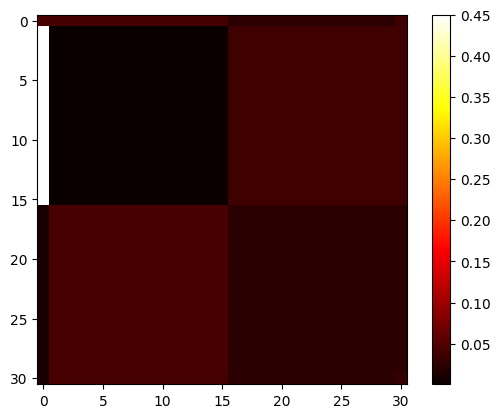

In [52]:
k = 45
plt.imshow(A[k,:,:].cpu().data, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

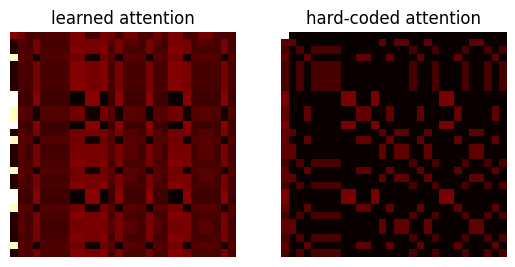

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2)

_,_, A = gptmini(one_sample.to(device), verbose=True)
ax1.imshow(A[0].cpu().data, cmap='hot', interpolation='nearest')
#plt.colorbar()
ax1.axis('off')
ax1.set_title('learned attention')
_, Ah = gh(one_sample)
ax2.imshow(Ah[0].cpu().data, cmap='hot', interpolation='nearest')
ax2.axis('off')
ax2.set_title('hard-coded attention')
plt.show()

[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)